## Define numerical solution of ODE

$\begin{equation}
\frac{d T_E}{dt} = R T_E + \gamma h_W \ 
\end{equation}$
$\begin{equation}
\frac{d h_W}{dt} =  - \alpha b T_E -r h_W
\end{equation} $ with initial condition(arbitrary) $ \begin{equation}
T_E(0) = 0.1, h_W(0) = -0.1
\end{equation}$
and coefficients are $ R = \gamma*b-c\ , b = b_0*mu $  
$c=1,\gamma=0.75,r=0.25,\alpha=0.125$, and $b_0= 2.5$.

- Let's solve it with 'RK4 method'

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import time as time

In [2]:
# differential equation for ENSO
def recharge_deriv(y, t, mu=2./3, en=0, c = 1.0, r= 0.25, alpha = 0.125, b0 = 2.5, gamma = 0.75): 
    '''
    input : variables, coefficients
    '''
    b = b0*mu  # coupling coefficient     
    R = gamma*b-c # Bjerknes coefficient
    T_E, h_w = y
    dT_dt = R * T_E + gamma * h_w - en*(h_w + b*T_E)**3
    dh_dt = -r * h_w - alpha * b * T_E
    return [dT_dt, dh_dt]  

# define numerical method
def RKM_4th(f, y, t, h):
    '''
    4th order Runge-Kutta method
    input : 함수, y, t, h
    output : y
    '''
    c1 = h*np.array(f(y, t))
    c2 = h*np.array(f(y+c1/2, t+h/2))
    c3 = h*np.array(f(y+c2/2, t+h/2))
    c4 = h*np.array(f(y+c3, t+h))
    y += (c1 + 2*c2 + 2*c3 + c4) / 6
    return y

# constants
max_time, h, tscale = 300, 0.01, 2
t = np.linspace(0, max_time, int(max_time/h)) #30000개
y_4th = np.zeros((len(t), 2)) 

# initial conditions
y_4th[0] = [0.1,-0.1]

#solving for ODEs
start = time.time()
for i in range(len(t)-1):
    yy = RKM_4th(recharge_deriv, y_4th[i], t[i], h)
    y_4th[i+1]=yy
end = time.time()

# Extract the results
T_E, h_w = y_4th[:,0], y_4th[:,1]

print(f"time for RK4 method : {end - start:.5f} sec")

time for RK4 method : 0.71707 sec


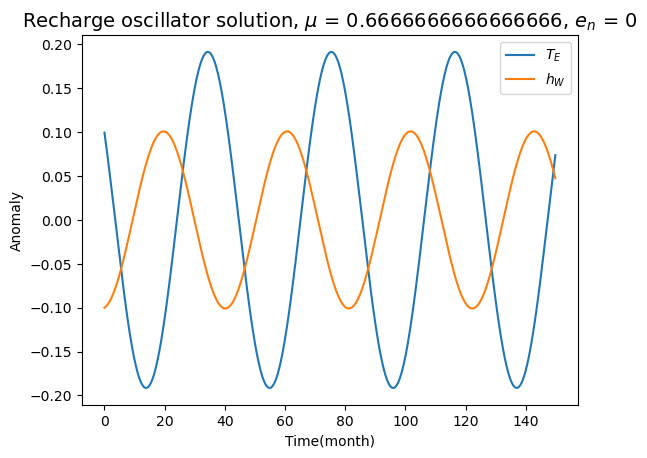

In [3]:
#plotting
mu, en = 2./3, 0
end_time = int(t.shape[0]/4) #7500
ts = t * tscale # tscale = 1/6

hdl = plt.plot(ts[:end_time:10], T_E[:end_time:10], ts[:end_time:10], h_w[:end_time:10])
plt.legend(hdl, [r'$T_E$',r'$h_W$'], loc = 'upper right')
plt.title(r'Recharge oscillator solution, $\mu$ = %s, $e_n$ = %s' %(mu, en), fontsize=14)
plt.ylabel('Anomaly')
plt.xlabel('Time(month)')
plt.show()

In [4]:
# Prepare simulation data 
numerical_soln = [T_E[:end_time:10], h_w[:end_time:10]] #750
numerical_data = np.zeros_like(numerical_soln)
tss = ts[:end_time:10] #750

# Adding gaussian noise to the simulation data = training data
numerical_data[0] = numerical_soln[0] + 0.01*np.random.randn(*numerical_soln[0].shape)
numerical_data[1] = numerical_soln[1] + 0.01*np.random.randn(*numerical_soln[1].shape)

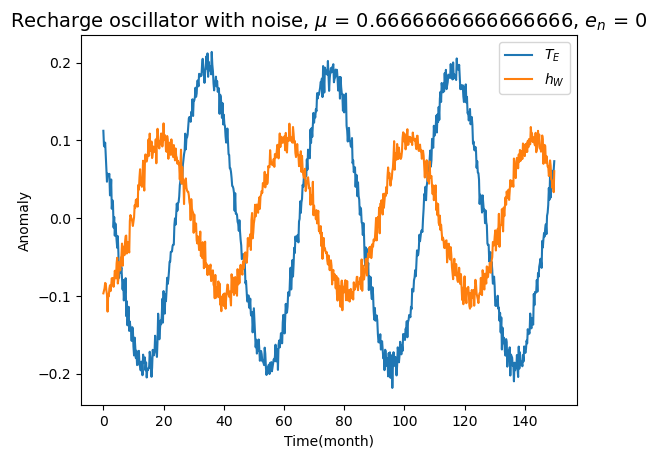

In [5]:

# Plotting the training data
hdll = plt.plot(tss, numerical_data[0], tss, numerical_data[1])
plt.legend(hdll, [r'$T_E$',r'$h_W$'], loc = 'upper right')
plt.xlabel('Time(month)')
plt.ylabel('Anomaly')
plt.title(r'Recharge oscillator with noise, $\mu$ = %s, $e_n$ = %s' %(mu, en), fontsize=14)
plt.show()

## Define DNN

In [6]:
# Prepare training data
t_train = tss.reshape(-1, 1)
T_E, h_W = numerical_data[0], numerical_data[1]
T_E_tr = T_E.reshape(-1, 1)
h_W_tr = h_W.reshape(-1, 1)


In [7]:
# Define the DNN model with 3 hidden layers
class DNN():
    def __init__(self, size, lr):
        self.size = size
        self.lr = lr 
        self.params = self.initialization()

    def initialization(self):
        input_size = self.size[0]
        hidden_size = self.size[1]
        output_size = self.size[2]
        #np.random.seed(42)
        params = {
            'W1' : np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size),
            'b1' : np.zeros((1, hidden_size)),
            'W2' : np.random.randn(hidden_size, hidden_size) * np.sqrt(1. / hidden_size),
            'b2' : np.zeros((1, hidden_size)),
            'W3' : np.random.randn(hidden_size, hidden_size) * np.sqrt(1. / hidden_size),
            'b3' : np.zeros((1, hidden_size)),
            'W4' : np.random.randn(hidden_size, hidden_size) * np.sqrt(1. / hidden_size),
            'b4' : np.zeros((1, hidden_size)),
            'W5' : np.random.randn(hidden_size, hidden_size) * np.sqrt(1. / hidden_size),
            'b5' : np.zeros((1, hidden_size)),
            'W6' : np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size),
            'b6' : np.zeros((1, output_size))
        }
        return params

    # Activation function (can be changed to tanh)
    def custom_activation(self, x, derivative=False):
        if derivative == True :
            return 2 * np.sin(x) * np.cos(x) + 1
            #return 1-(np.tanh(x))**2
        #return np.tanh(x)
        return np.sin(x) ** 2 + x
    

    # Forward pass
    def forward_pass(self, t):
        params = self.params
        params['I'] = t.reshape(-1,1)
        params['A1'] = np.dot(params['I'], params['W1']) + params['b1']
        params['R1'] = self.custom_activation(params['A1'])
        params['A2'] = np.dot(params['R1'], params['W2']) + params['b2']
        params['R2'] = self.custom_activation(params['A2'])
        params['A3']= np.dot(params['R2'], params['W3']) + params['b3']
        params['R3'] = self.custom_activation(params['A3'])
        params['A4']= np.dot(params['R3'], params['W4']) + params['b4']
        params['R4'] = self.custom_activation(params['A4'])
        params['A5']= np.dot(params['R4'], params['W5']) + params['b5']
        params['R5'] = self.custom_activation(params['A5'])
        params['O'] = np.dot(params['R5'], params['W6']) + params['b6']
        return params['O']

    # Mean squared error loss
    def loss_function(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    # Gradient clipping function
    def clip_gradients(self, grad, clip_value):
        return np.clip(grad, -clip_value, clip_value)

    # Backward propagation
    def backward_pass(self, T_E_train, h_W_train, output):
        m = T_E_train.shape[0]
        params = self.params
        change_params = {}

        dL_dO = 2 * (output - np.hstack((T_E_train, h_W_train))) / m
        change_params['W6'] = np.dot(params['R5'].T, dL_dO)
        change_params['b6'] = np.sum(dL_dO, axis=0, keepdims=True)

        dL_dz5 = np.multiply(np.dot(dL_dO, params['W6'].T), self.custom_activation(params['A5'], derivative=True))
        change_params['W5'] = np.dot(params['R4'].T, dL_dz5)
        change_params['b5'] = np.sum(dL_dz5, axis=0, keepdims=True)

        dL_dz4 = np.multiply(np.dot(dL_dz5, params['W5'].T), self.custom_activation(params['A4'], derivative=True))
        change_params['W4'] = np.dot(params['R3'].T, dL_dz4)
        change_params['b4'] = np.sum(dL_dz5, axis=0, keepdims=True)
  
        dL_dz3 = np.multiply(np.dot(dL_dz4, params['W4'].T), self.custom_activation(params['A3'], derivative=True))
        change_params['W3'] = np.dot(params['R2'].T, dL_dz3)
        change_params['b3'] = np.sum(dL_dz3, axis=0, keepdims=True)
  
        dL_dz2 = np.multiply(np.dot(dL_dz3, params['W3'].T), self.custom_activation(params['A2'], derivative=True))
        change_params['W2'] = np.dot(params['R1'].T, dL_dz2)
        change_params['b2'] = np.sum(dL_dz2, axis=0, keepdims=True)
        
        dL_dz1 = np.multiply(np.dot(dL_dz2, params['W2'].T), self.custom_activation(params['A1'], derivative=True))
        change_params['W1'] = np.dot(params['I'].T, dL_dz1)
        change_params['b1'] = np.sum(dL_dz1, axis=0, keepdims=True)
        return change_params
    
    def update_network_params(self, changes_to_params, clip_value=1.0):
        # Clip gradients # Update parameters
        for key, value in changes_to_params.items():
            self.params[key] -= self.lr * self.clip_gradients(value, clip_value)

dnn = DNN(size=[1,256,2], lr=1e-6)
loss_list = []
epochs = 50000
# Training the DNN model
for epoch in range(epochs):
    #dnn.train()
    pred = dnn.forward_pass(t_train)
    loss = dnn.loss_function(np.hstack((T_E_tr, h_W_tr)), pred)
    loss_list.append(loss)
    changes_to_params = dnn.backward_pass(T_E_tr, h_W_tr, pred)
    dnn.update_network_params(changes_to_params)
    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss:.7f}')


Epoch [200/50000], Loss: 0.5125566
Epoch [400/50000], Loss: 0.4661309
Epoch [600/50000], Loss: 0.4383290
Epoch [800/50000], Loss: 0.4188647
Epoch [1000/50000], Loss: 0.4035476
Epoch [1200/50000], Loss: 0.3897789
Epoch [1400/50000], Loss: 0.3773221
Epoch [1600/50000], Loss: 0.3674723
Epoch [1800/50000], Loss: 0.3596790
Epoch [2000/50000], Loss: 0.3527993
Epoch [2200/50000], Loss: 0.3464994
Epoch [2400/50000], Loss: 0.3408729
Epoch [2600/50000], Loss: 0.3358360
Epoch [2800/50000], Loss: 0.3312144
Epoch [3000/50000], Loss: 0.3268926
Epoch [3200/50000], Loss: 0.3228632
Epoch [3400/50000], Loss: 0.3192262
Epoch [3600/50000], Loss: 0.3159592
Epoch [3800/50000], Loss: 0.3129646
Epoch [4000/50000], Loss: 0.3101849
Epoch [4200/50000], Loss: 0.3075756
Epoch [4400/50000], Loss: 0.3051164
Epoch [4600/50000], Loss: 0.3027767
Epoch [4800/50000], Loss: 0.3005294
Epoch [5000/50000], Loss: 0.2983490
Epoch [5200/50000], Loss: 0.2962129
Epoch [5400/50000], Loss: 0.2940992
Epoch [5600/50000], Loss: 0.2919

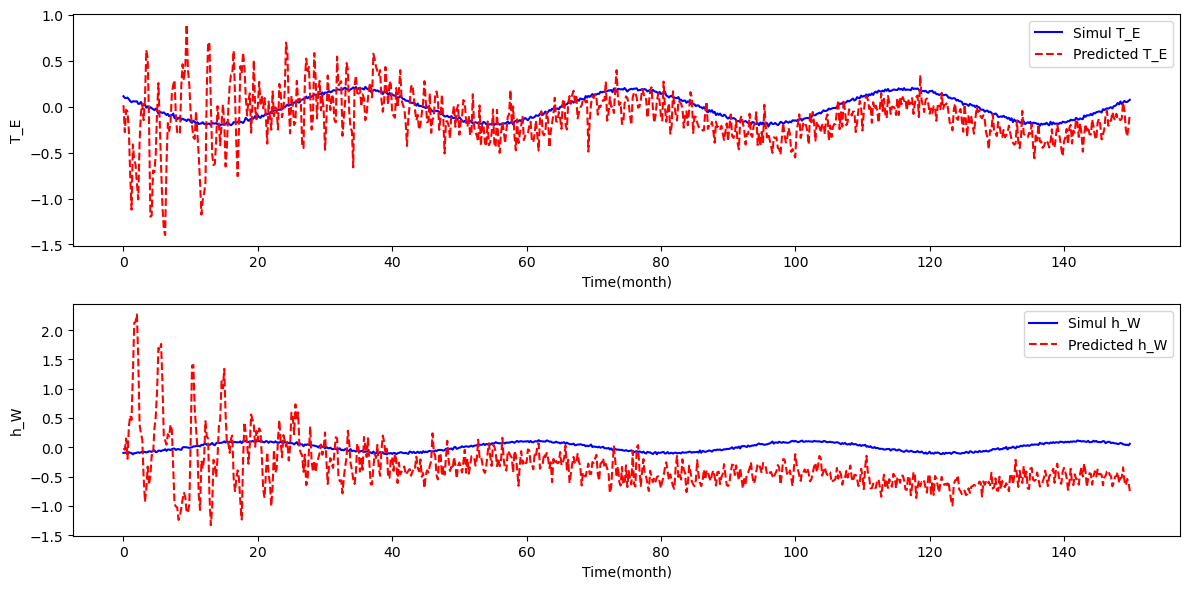

In [8]:

# Evaluate the model
output = dnn.forward_pass(t_train)
T_E_pred, h_W_pred = output[:, 0], output[:, 1]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tss, T_E, 'b-', label='Simul T_E')
plt.plot(tss, T_E_pred, 'r--', label='Predicted T_E')
plt.xlabel('Time(month)')
plt.ylabel('T_E')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tss, h_W, 'b-', label='Simul h_W')
plt.plot(tss, h_W_pred, 'r--', label='Predicted h_W')
plt.xlabel('Time(month)')
plt.ylabel('h_W')
plt.legend()

plt.tight_layout()
plt.show()


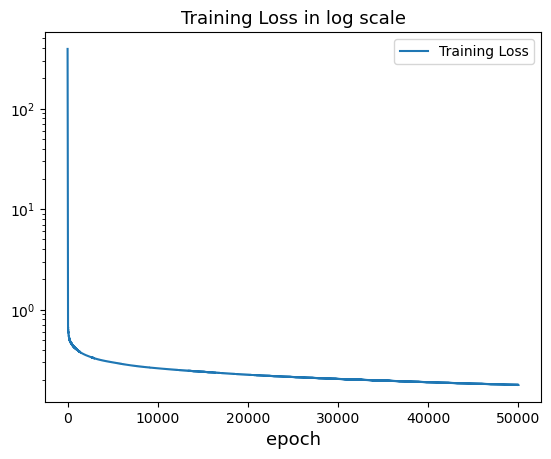

In [9]:
plt.plot(loss_list, label='Training Loss')
plt.yscale('log')
plt.legend()
#plt.ylim(0.5,0.75) #제대로 줄어들지 않고 있음
plt.title('Training Loss in log scale', fontsize=13)
plt.xlabel('epoch', fontsize=13)
plt.show()

## Define PINN

1. set a NN model  
2. training  
3. testing  



In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

In [20]:
# Define the new activation function
def custom_activation(x):
    return torch.sin(x)**2 + x
    #return torch.tanh(x)

# Define the PINN model with n hidden layers
class model(nn.Module):
    def __init__(self, hidden_nodes=128) :
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_nodes)
        self.fc2 = nn.Linear(hidden_nodes, hidden_nodes)
        self.fc3 = nn.Linear(hidden_nodes, hidden_nodes)
        self.fc4 = nn.Linear(hidden_nodes, hidden_nodes)
        #self.fc5 = nn.Linear(hidden_nodes, hidden_nodes)
        self.fc6 = nn.Linear(hidden_nodes, 2)
        self.initialization_weights()

    def initialization_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
        
    def forward(self, t) : 
        x = custom_activation(self.fc1(t))
        x = custom_activation(self.fc2(x))
        x = custom_activation(self.fc3(x))
        x = custom_activation(self.fc4(x))
        #x = custom_activation(self.fc5(x))
        output = self.fc6(x)
        return output

In [21]:
# Prepare training data
T_E_tr, h_w_tr = torch.tensor(numerical_data[0], dtype=torch.float32).view(-1,1), torch.tensor(numerical_data[1], dtype=torch.float32).view(-1,1)
tss_tr = torch.tensor(tss, dtype=torch.float32).view(-1,1).requires_grad_(True) #500개

PINN = model(hidden_nodes=128)

# Loss function
loss_f = nn.MSELoss()

# Define the opitmizer
optimizer = optim.Adam(PINN.parameters(), lr=0.0004) 

In [22]:
# Define derivation
def derivative(y, t) : 
    '''output : dh/dt, dT/dt'''
    return torch.autograd.grad(y, t, create_graph=True,\
                            grad_outputs=torch.ones_like(y))[0]

# Physics-informed loss function
def physics_informed_loss(model, t):
    pred = model(t)
    T_E_pred, h_w_pred = pred[:, 0:1], pred[:, 1:2]
    
    # Calculate the derivative
    dT_E_pred = derivative(T_E_pred, t)
    dh_w_pred = derivative(h_w_pred, t)

    # Physics loss
    c,r,alpha,b0,gamma,mu = 1.0, 0.25, 0.125, 2.5, 0.75, 2./3
    b = b0*mu 
    R = gamma*b-c
    loss_T_E = dT_E_pred - (R * dT_E_pred + gamma * dh_w_pred)
    loss_h_W = dh_w_pred + alpha * b * dT_E_pred + r * dh_w_pred
    
    # MSE loss
    physics_loss = torch.mean(loss_T_E**2) + torch.mean(loss_h_W**2)
    
    return physics_loss

In [23]:
total_loss_list = []
r_data, r_ode = 1, 1

# Training the PINN model
epoch = 10000
for i in range(epoch) :
    PINN.train()
    optimizer.zero_grad() 

    pred = PINN(tss_tr) 

    # Data loss
    loss_data = loss_f(pred[:,0:1],T_E_tr) + loss_f(pred[:,1:2],h_w_tr)
    
    # Physics-informed loss
    loss_ode = physics_informed_loss(PINN, tss_tr)
    
    # Total loss(not consider initial loss)
    loss = r_data*loss_data + r_ode*loss_ode
    
    loss.backward()
    optimizer.step()
    
    total_loss_list.append(loss.item())

    if not i % 200 :
        print('EPOCH : %6d/%6d | Loss_data : %8.7f | Loss_ode : %8.7f ' %(i, epoch, loss_data.item(), loss_ode.item()))
        print('total Loss : %8.7f ' %(total_loss_list[-1]))
        print('-'*100)

print('Training Finished.')

EPOCH :      0/ 10000 | Loss_data : 855.0842285 | Loss_ode : 0.4698569 
total Loss : 855.5540771 
----------------------------------------------------------------------------------------------------
EPOCH :    200/ 10000 | Loss_data : 0.0359520 | Loss_ode : 0.0128881 
total Loss : 0.0488400 
----------------------------------------------------------------------------------------------------
EPOCH :    400/ 10000 | Loss_data : 0.0075526 | Loss_ode : 0.0054586 
total Loss : 0.0130112 
----------------------------------------------------------------------------------------------------
EPOCH :    600/ 10000 | Loss_data : 0.0026011 | Loss_ode : 0.0036017 
total Loss : 0.0062029 
----------------------------------------------------------------------------------------------------
EPOCH :    800/ 10000 | Loss_data : 0.0014463 | Loss_ode : 0.0027968 
total Loss : 0.0042431 
----------------------------------------------------------------------------------------------------
EPOCH :   1000/ 10000

Text(0.5, 0, 'tss')

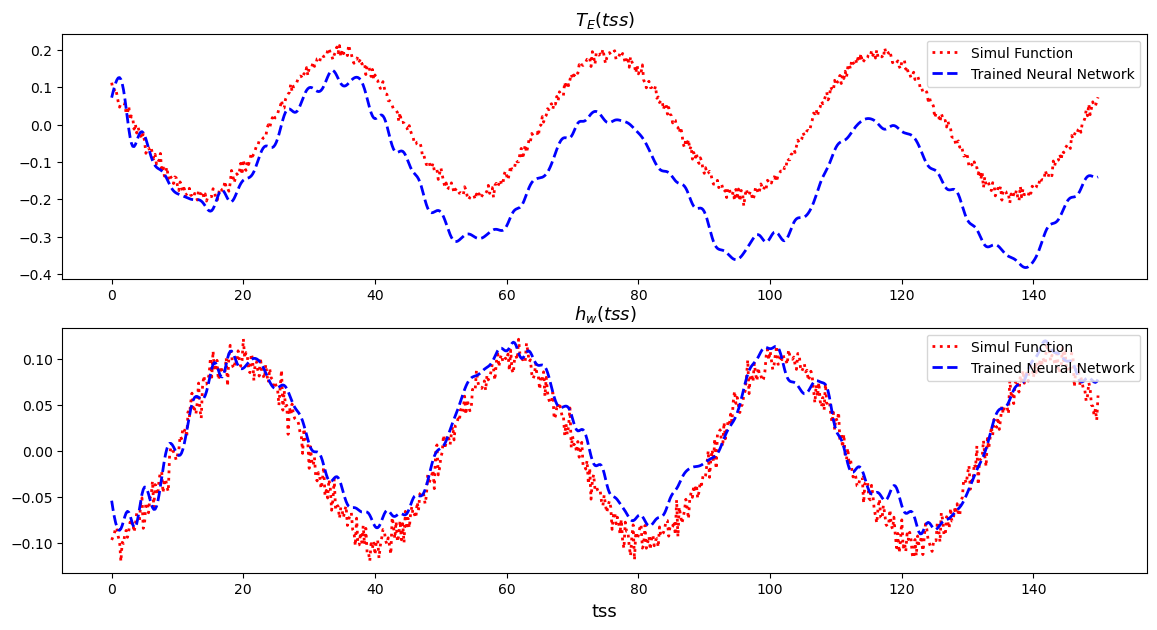

In [15]:
#print('Mean Square Error for $y_1(t)$ : %8.7f' %((PINN(ts)[:,0].view(-1,1) - torch.sin(t))**2).mean())
#print('Mean Square Error for $y_2(t)$ : %8.7f' %((PINN(ts)[:,1].view(-1,1) - torch.cos(t))**2).mean())

PINN.eval()
with torch.no_grad():
    pred = PINN(tss_tr)
    T_E_eval, h_w_eval = pred[:, 0].numpy(), pred[:, 1].numpy()

# Plotting the results
figure = plt.figure(figsize=(14,7))

ax1 = figure.add_subplot(2,1,1)
ax1.plot(tss_tr.detach().numpy(), T_E_tr.detach().numpy(),\
         linestyle='dotted', lw=2, color='r', label='Simul Function')
ax1.plot(tss_tr.detach().numpy(), T_E_eval,\
         linestyle='--', lw=2, color='b', label='Trained Neural Network')
ax1.legend(loc = 'upper right')
ax1.set_title('$T_E(tss)$', fontsize=13)
#ax1.set_xlabel('tss', fontsize=13)

ax2 = figure.add_subplot(2,1,2)
ax2.plot(tss_tr.detach().numpy(), h_w_tr.detach().numpy(),\
         linestyle='dotted', lw=2, color='r', label='Simul Function')
ax2.plot(tss_tr.cpu().detach().numpy(), h_w_eval,\
         linestyle='--', lw=2, color='b', label='Trained Neural Network')
ax2.legend(loc = 'upper right')
ax2.set_title('$h_w(tss)$', fontsize=13)
ax2.set_xlabel('tss', fontsize=13)


Text(0.5, 0, 'epoch')

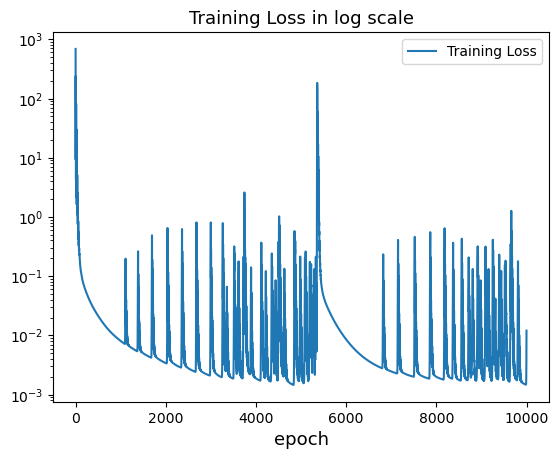

In [16]:
plt.plot(total_loss_list, label='Training Loss')
#plt.ylim(0,0.05)
plt.yscale('log')
plt.legend()
plt.title('Training Loss in log scale', fontsize=13)
plt.xlabel('epoch', fontsize=13)

#plt.savefig('ode', dpi=100)